In [32]:
import torch
import json
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from utils.dataset import load_dataset
from models.detector import RetinoblastomaDetector

In [33]:
# Load the dataset
data_dir = "Training"
_, validation_loader, class_names = load_dataset(data_dir, validation_split=0.2, batch_size=32)

In [34]:
# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RetinoblastomaDetector().to(device)
# Load the model state dictionary safely
state_dict = torch.load("models/retinoblastoma_detector.pth", weights_only=True)
model.load_state_dict(state_dict)
model.eval()

RetinoblastomaDetector(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=200704, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

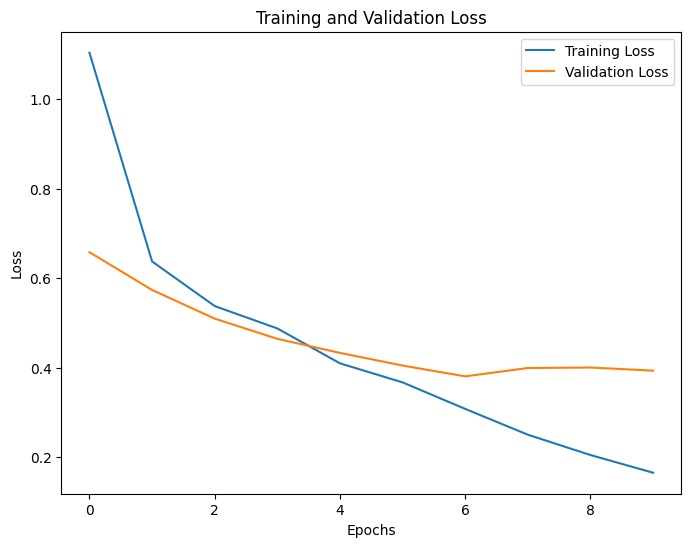

Classification Report:
                precision    recall  f1-score   support

           eye       0.94      0.94      0.94        16
retinoblastoma       0.93      0.93      0.93        15

      accuracy                           0.94        31
     macro avg       0.94      0.94      0.94        31
  weighted avg       0.94      0.94      0.94        31

Confusion Matrix:
[[15  1]
 [ 1 14]]
ROC-AUC Score: 0.97


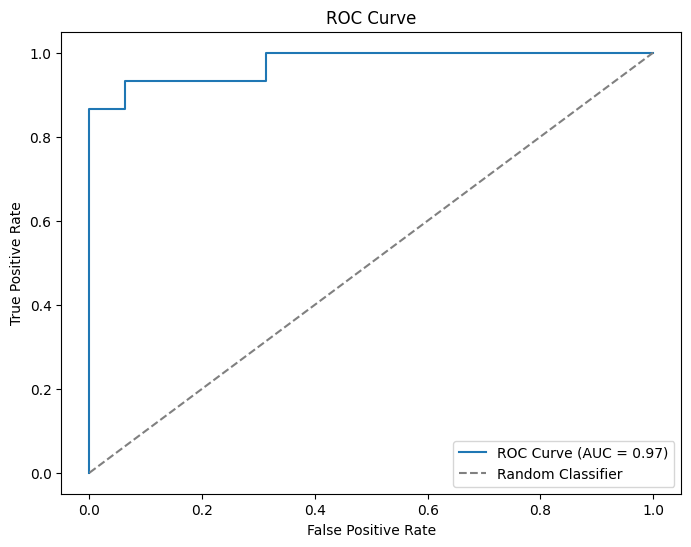

In [35]:
# Load the saved loss data
with open("models/losses.json", "r") as f:
    loss_data = json.load(f)

train_losses = loss_data["train_losses"]
validation_losses = loss_data["validation_losses"]

# Plot the loss curves
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label="Training Loss")
plt.plot(validation_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# Evaluate the model
all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for images, labels in validation_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        # Apply threshold
        probabilities = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
        predictions = (probabilities > 0.4).astype(int)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predictions)
        all_probs.extend(probabilities)

# Compute evaluation metrics
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=1))
print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))

roc_auc = roc_auc_score(all_labels, all_probs)
print(f"ROC-AUC Score: {roc_auc:.2f}")

# Plot the ROC Curve
fpr, tpr, _ = roc_curve(all_labels, all_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [36]:
import os
import torch
from PIL import Image
from torchvision import transforms
from models.detector import RetinoblastomaDetector

# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RetinoblastomaDetector().to(device)

# Load model weights safely
state_dict = torch.load("models/retinoblastoma_detector.pth", weights_only=True)
model.load_state_dict(state_dict)
model.eval()

# Define preprocessing for a single image (same as validation)
transform = transforms.Compose([
    transforms.Resize((224, 224)),      # Resize to match training dimensions
    transforms.ToTensor(),              # Convert to PyTorch tensor
    transforms.Normalize([0.5], [0.5])  # Normalize using training stats
])

# Specify the image path
image_path = r"C:\Users\amirn\Documents\GitHub\Retinoblastoma_Detector\Training\retinoblastoma\retinoblastoma_50.jpg"  # Replace with the actual image path

# Check if the file exists
if not os.path.exists(image_path):
    print(f"Error: File not found at {image_path}. Please verify the file path.")
else:
    try:
        # Load and preprocess the image
        image = Image.open(image_path).convert("RGB")  # Ensure RGB format
        input_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension

        # Predict using the model
        with torch.no_grad():
            output = model(input_tensor)

            # Apply softmax to get probabilities
            probabilities = torch.softmax(output, dim=1)[0]

            # Custom threshold for binary classification
            threshold = 0.45
            confidence, predicted_class = probabilities.max(0)
            if probabilities[1] > threshold:
                predicted_class = 1  # Retinoblastoma
                confidence = probabilities[1]
            else:
                predicted_class = 0  # Healthy Eye
                confidence = probabilities[0]

        # Map predictions to class names
        class_names = ["Healthy Eye", "Retinoblastoma"]
        print(f"Predicted Class: {class_names[predicted_class]}, Confidence: {confidence:.2%}")

    except Exception as e:
        print(f"An error occurred while processing the image: {e}")

Predicted Class: Retinoblastoma, Confidence: 66.13%
